In [3]:
import pandas as pd




,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [1]:
def get_words(doc):
    words = [s.lower() for s in
    doc.split()]
    # Return the unique set of words
    return dict([(w,1) for w in words])

In [8]:
s1 = "The fox jumps jumps over the lazy dog"
print(get_words(s1))

{'the': 1, 'fox': 1, 'jumps': 1, 'over': 1, 'lazy': 1, 'dog': 1}


In [23]:

class Classifier:
    def __init__(self):
        self.fc = {} # counts of feature/category combinations
        self.cc = {} # counts of documents in each category
#    Increase the count of a feature/category pair
    def incf(self,f,cat):
        self.fc.setdefault(f,{})
        self.fc[f].setdefault(cat,0)
        self.fc[f][cat]+=1
    # Increase the count of a category
    def incc(self,cat):
        self.cc.setdefault(cat,0)
        self.cc[cat]+=1
# The number of times a feature has appeared in a category
    def fcount(self,f,cat):
        if f in self.fc and cat in self.fc[f]:
            return float(self.fc[f][cat])
        return 0.0
    # The number of items in a category
    def catcount(self,cat):
        if cat in self.cc:
            return float(self.cc[cat])
        return 0
    # The total number of items
    def totalcount(self):
        return sum(self.cc.values())
    # The list of all categories
    def categories(self):
        return self.cc.keys()
    def train(self,doc,cat):
        features = get_words(doc)
        # Increment the count for every feature with this category
        for f in features:
            self.incf(f,cat)
        # Increment the count for this category
        self.incc(cat)
    def fprob(self,f,cat):
        if self.catcount(cat)==0: return 0
        # The total number of times this feature appeared in this category divided by count of items in this category
        return self.fcount(f,cat)/self.catcount(cat)
    def weightedprob(self,f,cat,prf,weight=1.0,ap=0.5):
        # Calculate current probability
        basicprob=prf(f,cat)
        # Count the number of times this feature has appeared in
        # all categories
        totals=sum([self.fcount(f,c) for c in self.categories()])
        # Calculate the weighted average
        bp=((weight*ap)+(totals*basicprob))/(weight+totals)
        return bp

In [15]:
cl = Classifier()


cl.train('the quick brown fox jumps over the lazy dog','ham')

print(cl.fcount('quick','ham'))
print(cl.fcount('quick','spam'))

1.0
0.0


In [17]:
cl = Classifier()


cl.train('make quick money with us','spam')

print(cl.fcount('quick','ham'))
print(cl.fcount('quick','spam'))

0.0
1.0


In [21]:
def sampletrain(cl):
    cl.train('Nobody owns the water', 'ham')
    cl.train('the quick rabbit jumps fences', 'ham')
    cl.train('buy pharmaceuticals now', 'spam')
    cl.train('make quick money at the online casino', 'spam')
    cl.train('the quick brown fox jumps', 'ham')

cl = Classifier()
sampletrain(cl)
cl.fprob('quick','ham')

0.6666666666666666

In [24]:
def sampletrain(cl):
    cl.train('Nobody owns the water', 'ham')
    cl.train('the quick rabbit jumps fences', 'ham')
    cl.train('buy pharmaceuticals now', 'spam')
    cl.train('make quick money at the online casino', 'spam')
    cl.train('the quick brown fox jumps', 'ham')

cl = Classifier()
sampletrain(cl)
cl.weightedprob('money','spam',cl.fprob, 1.0,0.5)

0.5

In [42]:
class NaiveBayes(Classifier):
    def __init__(self):
        Classifier.__init__(self)
        #used the hold the thresholds for each category
        self.thresholds={}

    def setthreshold(self,cat,t):
        self.thresholds[cat]=t

    def getthreshold(self,cat):
        if cat not in self.thresholds: return 1.0
        return self.thresholds[cat]

    def get_words(self, doc):
        words = [s.lower() for s in doc.split()]
        # Return the unique set of words
        return dict([(w,1) for w in words])

    def docprob(self, item, cat):
        features=self.get_words(item)
        # Multiply the probabilities of all the features together
        p = 1
        for f in features: 
            p*=self.weightedprob(f, cat, self.fprob)
        return p
    
    def prob(self,item,cat):
        catprob=self.catcount(cat)/self.totalcount()
        docprob=self.docprob(item,cat)
        return docprob*catprob
    
    def weightedprob(self,f,cat,prf,weight=1.0,ap=0.5):
        # Calculate current probability
        basicprob=prf(f,cat)
        # Count the number of times this feature has appeared in
        # all categories
        totals=sum([self.fcount(f,c) for c in self.categories()])
        # Calculate the weighted average
        bp=((weight*ap)+(totals*basicprob))/(weight+totals)
        return bp
    
    def classify(self,item,default=None):
        probs={}
        # Find the category with the highest probability
        max=0.0
        for cat in self.categories():
            probs[cat]=self.prob(item,cat)
            if probs[cat]>max:
                max=probs[cat]
                best=cat
        # Make sure the probability exceeds threshold*next best
        for cat in probs:
            if cat==best: continue
            if probs[cat]*self.getthreshold(best)>probs[best]: return default
        return best

In [53]:
cl = NaiveBayes()
sampletrain(cl)

print(cl.prob('quick rabbit', 'ham'))
print(cl.prob('quick rabbit', 'spam'))

0.15624999999999997
0.05


In [44]:
c1 = NaiveBayes()
sampletrain(c1)

print(c1.classify('quick money', default='unknown'))

c1.setthreshold('spam', 3.0)
print(c1.classify('quick money', default='unknown'))

spam
unknown


In [47]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# Load the SMS Spam Collection Dataset
sms_data = pd.read_csv('CSVs-Data/spam.csv', encoding='latin-1')
# url: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
# Preprocess the data
sms_data = sms_data[['v1', 'v2']]
sms_data = sms_data.rename(columns={'v1': 'label', 'v2': 'text'})
# Split the data into features and labels
X = sms_data['text']
y = sms_data['label']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [48]:
# Create a CountVectorizer to convert text data into numerical features
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [49]:
# Train a Multinomial Naive Bayes classifier
mnb = MultinomialNB()
mnb.fit(X_train_vec, y_train)

MultinomialNB()

In [50]:
from sklearn.metrics import accuracy_score, f1_score
y_pred_mnb = mnb.predict(X_test_vec)
accuracy_mnb = accuracy_score(y_test, y_pred_mnb)
f1_mnb = f1_score(y_test, y_pred_mnb, pos_label='spam')
print(accuracy_mnb)
print(f1_mnb)

0.9820574162679426
0.9282296650717703


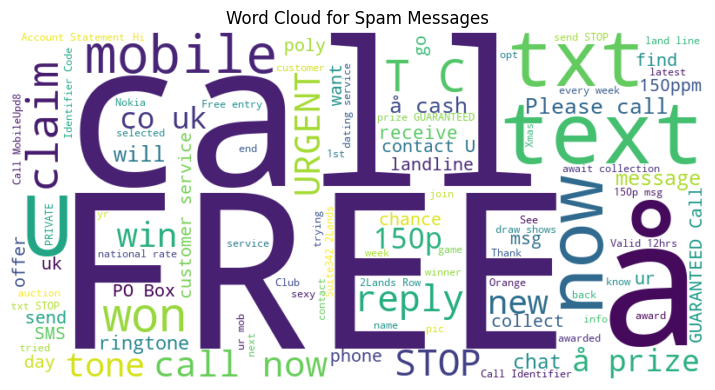

In [52]:
# pull only the text of the spam messages
spam_text = ' '.join(sms_data[sms_data['label'] == 'spam']['text'])
from wordcloud import WordCloud
import matplotlib.pyplot as plt
spam_wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white',
random_state=42).generate(spam_text)
plt.figure(figsize=(10, 4))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Spam Messages')
plt.axis('off')
plt.tight_layout()
plt.show()